# Register and visualize dataset

### Introduction

Use AWS data stack services such as AWS Glue and Amazon Athena for ingesting and querying a dataset. Use AWS Data Wrangler to analyze the dataset and plot some visuals extracting insights.

Bias can be present in your data before any model training occurs. Inspecting the dataset for bias can help detect collection gaps, inform your feature engineering, and understand societal biases the dataset may reflect. We will analyze bias on the dataset, generate and analyze bias report, and prepare the dataset for the model training.

### Table of Contents

- [1. Ingest and transform the public dataset](#c1w1-1.)
  - [1.1. List the dataset files in the public S3 bucket](#c1w1-1.1.)
  - [1.2. Copy the data locally to the notebook](#c1w1-1.2.)
  - [1.3. Transform the data](#c1w1-1.3.)
  - [1.4 Write the data to a CSV file](#c1w1-1.4.)
- [2. Register the public dataset for querying and visualizing](#c1w1-2.)
  - [2.1. Register S3 dataset files as a table for querying](#c1w1-2.1.)
  - [2.2. Create default S3 bucket for Amazon Athena](#c1w1-2.2.)
- [3. Visualize data](#c1w1-3.)
  - [3.1. Preparation for data visualization](#c1w1-3.1.)
  - [3.2. How many reviews per sentiment?](#c1w1-3.2.)
  - [3.3. Which product categories are highest rated by average sentiment?](#c1w1-3.3.)
  - [3.4. Which product categories have the most reviews?](#c1w1-3.4.)
  - [3.5. What is the breakdown of sentiments per product category?](#c1w1-3.5.)
  - [3.6. Analyze the distribution of review word counts](#c1w1-3.6.)
- [4. Analyze class imbalance on the dataset with Amazon SageMaker Clarify](#c1w2-2.)
  - [4.1. Configure a `DataConfig`](#c1w2-2.1.)
  - [4.2. Configure `BiasConfig`](#c1w2-2.2.)
  - [4.3. Configure Amazon SageMaker Clarify as a processing job](#c1w2-2.3.)
  - [4.4. Run the Amazon SageMaker Clarify processing job](#c1w2-2.4.)
  - [4.5. Run and review the Amazon SageMaker Clarify processing job on the unbalanced dataset](#c1w2-2.5.)
  - [4.6. Analyze unbalanced bias report](#c1w2-2.6.)
- [5. Balance the dataset by `product_category` and `sentiment`](#c1w2-3.)
- [6. Analyze bias on balanced dataset with Amazon SageMaker Clarify](#c1w2-4.)
  - [6.1. Configure a `DataConfig`](#c1w2-4.1.)
  - [6.2. Configure `BiasConfig`](#c1w2-4.2.)
  - [6.3. Configure SageMaker Clarify as a processing job](#c1w2-4.3.)
  - [6.4. Run the Amazon SageMaker Clarify processing job](#c1w2-4.4.)
  - [6.5. Run and review the Clarify processing job on the balanced dataset](#c1w2-4.5.)
  - [6.6. Analyze balanced bias report](#c1w2-4.6.)

Let's install the required modules first.

In [1]:
# please ignore warning messages during the installation
!pip install --disable-pip-version-check -q sagemaker==2.35.0
!pip install --disable-pip-version-check -q pandas==1.1.4
!pip install --disable-pip-version-check -q awswrangler==2.7.0
!pip install --disable-pip-version-check -q numpy==1.18.5
!pip install --disable-pip-version-check -q seaborn==0.11.0
!pip install --disable-pip-version-check -q matplotlib===3.3.3

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils 

<a name='c1w1-1.'></a>
# 1. Ingest and transform the public dataset

The dataset [Women's Clothing Reviews](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews) has been chosen as the main dataset.

It is shared in a public Amazon S3 bucket, and is available as a comma-separated value (CSV) text format:

`s3://dlai-practical-data-science/data/raw/womens_clothing_ecommerce_reviews.csv`

<a name='c1w1-1.1.'></a>
### 1.1. List the dataset files in the public S3 bucket

The [AWS Command Line Interface (CLI)](https://awscli.amazonaws.com/v2/documentation/api/latest/index.html) is a unified tool to manage your AWS services. With just one tool, you can control multiple AWS services from the command line and automate them through scripts. You will use it to list the dataset files.

**View dataset files in CSV format**

```aws s3 ls [bucket_name]``` function lists all objects in the S3 bucket. Let's use it to view the reviews data files in CSV format:


View the list of the files available in the public bucket `s3://dlai-practical-data-science/data/raw/`.


In [2]:
!aws s3 ls s3://dlai-practical-data-science/data/raw/

2021-04-30 02:21:06    8457214 womens_clothing_ecommerce_reviews.csv


<a name='c1w1-1.2.'></a>
### 1.2. Copy the data locally to the notebook

```aws s3 cp [bucket_name/file_name] [file_name]``` function copies the file from the S3 bucket into the local environment or into another S3 bucket. Let's use it to copy the file with the dataset locally.

In [3]:
## Remove comment below if not already in data folder
#!aws s3 cp s3://dlai-practical-data-science/data/raw/womens_clothing_ecommerce_reviews.csv ./data/raw/womens_clothing_ecommerce_reviews.csv

Now use the Pandas dataframe to load and preview the data.

In [4]:
import pandas as pd
import csv

df = pd.read_csv('./data/raw/womens_clothing_ecommerce_reviews.csv',
                 index_col=0)

df.shape

(23486, 10)

In [5]:
df

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,847,33,"Cute, crisp shirt",If this product was in petite i would get the...,4,1,2,General,Tops,Blouses
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,I love love love this jumpsuit. it's fun fl...,5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,862,48,Wish it was made of cotton,It reminds me of maternity clothes. soft stre...,3,1,0,General Petite,Tops,Knits
23483,1104,31,"Cute, but see through",This fit well but the top was very see throug...,3,0,1,General Petite,Dresses,Dresses
23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


<a name='c1w1-1.3.'></a>
### 1.3. Transform the data
To simplify the task, transform the data into a comma-separated value (CSV) file that contains only a `review_body`, `product_category`, and `sentiment` derived from the original data.

In [6]:
df_transformed = df.rename(columns={'Review Text': 'review_body',
                                    'Rating': 'star_rating',
                                    'Class Name': 'product_category'})
df_transformed.drop(columns=['Clothing ID', 'Age', 'Title', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name'],
                    inplace=True)

df_transformed.dropna(inplace=True)

df_transformed.shape

(22628, 3)

Convert the `star_rating` into the `sentiment` (positive, neutral, negative), which later on will be for the prediction.

In [7]:
def to_sentiment(star_rating):
    if star_rating in {1, 2}: # negative
        return -1 
    if star_rating == 3:      # neutral
        return 0
    if star_rating in {4, 5}: # positive
        return 1

# transform star_rating into the sentiment
df_transformed['sentiment'] = df_transformed['star_rating'].apply(lambda star_rating: 
    to_sentiment(star_rating=star_rating) 
)

# drop the star rating column
df_transformed.drop(columns=['star_rating'],
                    inplace=True)

# remove reviews for product_categories with < 10 reviews
df_transformed = df_transformed.groupby('product_category').filter(lambda reviews : len(reviews) > 10)[['sentiment', 'review_body', 'product_category']]

df_transformed.shape

(22626, 3)

In [8]:
# preview the results
df_transformed

,sentiment,review_body,product_category
0,1,If this product was in petite i would get the...,Blouses
1,1,Love this dress! it's sooo pretty. i happene...,Dresses
2,0,I had such high hopes for this dress and reall...,Dresses
3,1,I love love love this jumpsuit. it's fun fl...,Pants
4,1,This shirt is very flattering to all due to th...,Blouses
...,...,...,...
23481,1,I was very happy to snag this dress at such a ...,Dresses
23482,0,It reminds me of maternity clothes. soft stre...,Knits
23483,0,This fit well but the top was very see throug...,Dresses
23484,0,I bought this dress for a wedding i have this ...,Dresses


<a name='c1w1-1.4.'></a>
### 1.4 Write the data to a CSV file

In [9]:
df_transformed.to_csv('./data/transformed/womens_clothing_ecommerce_reviews_transformed.csv', 
                      index=False)

In [10]:
!head -n 5 ./data/transformed/womens_clothing_ecommerce_reviews_transformed.csv

sentiment,review_body,product_category
1,If this product was in petite  i would get the petite. the regular is a little long on me but a tailor can do a simple fix on that.     fits nicely! i'm 5'4  130lb and pregnant so i bough t medium to grow into.     the tie can be front or back so provides for some nice flexibility on form fitting.,Blouses
1,"Love this dress!  it's sooo pretty.  i happened to find it in a store  and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8"".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.",Dresses
0,I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium  which was just ok. overall  the top half was comfortable and fit nicely  but the bott

<a name='c1w1-2.'></a>
# 2. Register the public dataset for querying and visualizing
You will register the public dataset into an S3-backed database table so you can query and visualize our dataset at scale. 

<a name='c1w1-2.1.'></a>
### 2.1. Register S3 dataset files as a table for querying
Let's import required modules.

`boto3` is the AWS SDK for Python to create, configure, and manage AWS services, such as Amazon Elastic Compute Cloud (Amazon EC2) and Amazon Simple Storage Service (Amazon S3). The SDK provides an object-oriented API as well as low-level access to AWS services. 

`sagemaker` is the SageMaker Python SDK which provides several high-level abstractions for working with the Amazon SageMaker.

In [11]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import botocore

#config = botocore.config.Config(user_agent_extra='dlai-pds/c1/w1')

# low-level service client of the boto3 session
sm = boto3.client(service_name='sagemaker') #, config=config)

sess = sagemaker.Session(sagemaker_client=sm)                         

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name
account_id = sess.account_id

print('S3 Bucket: {}'.format(bucket))
print('Region: {}'.format(region))
print('Account ID: {}'.format(account_id))

S3 Bucket: sagemaker-eu-north-1-295482097746
Region: eu-north-1
Account ID: <bound method Session.account_id of <sagemaker.session.Session object at 0x7f085a20a1d0>>


Review the bucket which was created automatically for this account.


In [12]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/home?region={}#">Amazon S3 buckets</a></b>'.format(region)))

Copy the file into the S3 bucket.

In [13]:
!aws s3 cp ./data/transformed/womens_clothing_ecommerce_reviews_transformed.csv s3://$bucket/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv

upload: data/transformed/womens_clothing_ecommerce_reviews_transformed.csv to s3://sagemaker-eu-north-1-295482097746/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv


Review the bucket with the file we uploaded above.



In [14]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/buckets/{}?region={}&prefix=data/transformed/#">Amazon S3 buckets</a></b>'.format(bucket, region)))

**Import AWS Data Wrangler**

[AWS Data Wrangler](https://github.com/awslabs/aws-data-wrangler) is an AWS Professional Service open source python initiative that extends the power of Pandas library to AWS connecting dataframes and AWS data related services (Amazon Redshift, AWS Glue, Amazon Athena, Amazon EMR, Amazon QuickSight, etc).

Built on top of other open-source projects like Pandas, Apache Arrow, Boto3, SQLAlchemy, Psycopg2 and PyMySQL, it offers abstracted functions to execute usual ETL tasks like load/unload data from data lakes, data warehouses and databases.

Review the AWS Data Wrangler documentation: https://aws-data-wrangler.readthedocs.io/en/stable/

In [15]:
import awswrangler as wr

**Create AWS Glue Catalog database**

The data catalog features of **AWS Glue** and the inbuilt integration to Amazon S3 simplify the process of identifying data and deriving the schema definition out of the discovered data. Using AWS Glue crawlers within your data catalog, you can traverse your data stored in Amazon S3 and build out the metadata tables that are defined in your data catalog.

Here you will use `wr.catalog.create_database` function to create a database with the name `dsoaws_deep_learning` ("dsoaws" stands for "Data Science on AWS").

In [16]:
wr.catalog.create_database(
    name='dsoaws_deep_learning',
    exist_ok=True
)

In [17]:
dbs = wr.catalog.get_databases()

for db in dbs:
    print("Database name: " + db['Name'])

Database name: dsoaws_deep_learning
Database name: sagemaker_featurestore


Review the created database in the AWS Glue Catalog.

**Instructions**:
- open the link
- on the left side panel notice that you are in the AWS Glue -> Data Catalog -> Databases
- check that the database `dsoaws_deep_learning` has been created
- click on the name of the database
- click on the `Tables in dsoaws_deep_learning` link to see that there are no tables

In [18]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://console.aws.amazon.com/glue/home?region={}#catalog:tab=databases">AWS Glue Databases</a></b>'.format(region)))

**Register CSV data with AWS Glue Catalog**


Register CSV data with AWS Glue Catalog.


In [19]:
wr.catalog.create_csv_table(
    database='dsoaws_deep_learning', # 
    path='s3://{}/data/transformed/'.format(bucket), 
    table="reviews",    
    columns_types={
        'sentiment': 'int',        
        'review_body': 'string',
        'product_category': 'string'      
    },
    mode='overwrite',
    skip_header_line_count=1,
    sep=','
)

Review the registered table in the AWS Glue Catalog.


In [20]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://console.aws.amazon.com/glue/home?region={}#">AWS Glue Catalog</a></b>'.format(region)))

Review the table shape:

In [21]:
table = wr.catalog.table(database='dsoaws_deep_learning',
                         table='reviews')
table

,Column Name,Type,Partition,Comment
0,sentiment,int,False,
1,review_body,string,False,
2,product_category,string,False,


<a name='c1w1-2.2.'></a>
### 2.2. Create default S3 bucket for Amazon Athena

Amazon Athena requires this S3 bucket to store temporary query results and improve performance of subsequent queries.

The contents of this bucket are mostly binary and human-unreadable. 

In [22]:
# S3 bucket name
wr.athena.create_athena_bucket()

# EXPECTED OUTPUT
# 's3://aws-athena-query-results-ACCOUNT-REGION/'

's3://aws-athena-query-results-295482097746-eu-north-1/'

<a name='c1w1-3.'></a>
# 3. Visualize data

**Reviews dataset - column descriptions**

- `sentiment`: The review's sentiment (-1, 0, 1).
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `review_body`: The text of the review.

<a name='c1w1-3.1.'></a>
### 3.1. Preparation for data visualization

**Imports**

In [23]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

**Settings**

Set AWS Glue database and table name.

In [24]:
database_name = 'dsoaws_deep_learning'
table_name = 'reviews'

Set seaborn parameters. You can review seaborn documentation following the [link](https://seaborn.pydata.org/index.html).

In [25]:
sns.set_style = 'seaborn-whitegrid'

sns.set(rc={"font.style":"normal",
            "axes.facecolor":"white",
            'grid.color': '.8',
            'grid.linestyle': '-',
            "figure.facecolor":"white",
            "figure.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":True,
            'axes.labelsize':10,
            'xtick.labelsize':10,
            'font.size':10,
            'ytick.labelsize':10})

Helper code to display values on barplots:

**Run SQL queries using Amazon Athena**

**Amazon Athena** lets you query data in Amazon S3 using a standard SQL interface. It reflects the databases and tables in the AWS Glue Catalog. You can create interactive queries and perform any data manipulations required for further downstream processing.

Standard SQL query can be saved as a string and then passed as a parameter into the Athena query. Run the following cells as an example to count the total number of reviews by sentiment.

<a name='c1w1-3.2.'></a>
### 3.2. How many reviews per sentiment?

Set the SQL statement to find the count of sentiments:

In [26]:
statement_count_by_sentiment = """
SELECT sentiment, COUNT(sentiment) AS count_sentiment
FROM reviews
GROUP BY sentiment
ORDER BY sentiment
"""

print(statement_count_by_sentiment)


SELECT sentiment, COUNT(sentiment) AS count_sentiment
FROM reviews
GROUP BY sentiment
ORDER BY sentiment



Query data in Amazon Athena database cluster using the prepared SQL statement:

In [27]:
df_count_by_sentiment = wr.athena.read_sql_query(
    sql=statement_count_by_sentiment,
    database=database_name
)

print(df_count_by_sentiment)

   sentiment  count_sentiment
0         -1             2370
1          0             2823
2          1            17433


Preview the results of the query:

<AxesSubplot:xlabel='sentiment'>

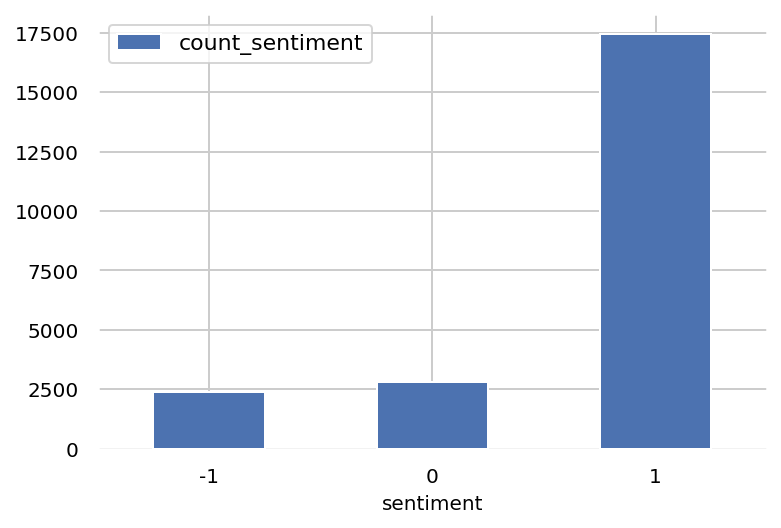

In [28]:
df_count_by_sentiment.plot(kind='bar', x='sentiment', y='count_sentiment', rot=0)


Use Amazon Athena query with the standard SQL statement passed as a parameter, to calculate the total number of reviews per `product_category` in the table ```reviews```.

(as a triple quote string into the variable `statement_count_by_category`)

In [29]:
statement_count_by_category = """
SELECT product_category, COUNT(sentiment) AS count_sentiment
FROM reviews
GROUP BY product_category 
ORDER BY count_sentiment DESC
"""
print(statement_count_by_category)


SELECT product_category, COUNT(sentiment) AS count_sentiment
FROM reviews
GROUP BY product_category 
ORDER BY count_sentiment DESC



Query data in Amazon Athena database passing the prepared SQL statement:

In [30]:
%%time
df_count_by_category = wr.athena.read_sql_query(
    sql=statement_count_by_category,
    database=database_name
)

df_count_by_category

# EXPECTED OUTPUT
# Dresses: 6145
# Knits: 4626
# Blouses: 2983
# Sweaters: 1380
# Pants: 1350
# ...

CPU times: user 240 ms, sys: 19.4 ms, total: 259 ms
Wall time: 3.27 s


,product_category,count_sentiment
0,Dresses,6145
1,Knits,4626
2,Blouses,2983
3,Sweaters,1380
4,Pants,1350
5,Jeans,1104
6,Fine gauge,1059
7,Skirts,903
8,Jackets,683
9,Lounge,669


<a name='c1w1-3.3.'></a>
### 3.3. Which product categories are highest rated by average sentiment?

Find the average sentiment per product category, showing the results in the descending order:

In [31]:
statement_avg_by_category = """
SELECT product_category, AVG(sentiment) AS avg_sentiment
FROM {} 
GROUP BY product_category 
ORDER BY avg_sentiment DESC
""".format(table_name)

print(statement_avg_by_category)


SELECT product_category, AVG(sentiment) AS avg_sentiment
FROM reviews 
GROUP BY product_category 
ORDER BY avg_sentiment DESC



Query data in Amazon Athena database passing the prepared SQL statement:

In [32]:
%%time
df_avg_by_category = wr.athena.read_sql_query(
    sql=statement_avg_by_category,
    database=database_name
)

CPU times: user 236 ms, sys: 20.7 ms, total: 256 ms
Wall time: 3.66 s


Preview the query results in the temporary S3 bucket:  `s3://aws-athena-query-results-ACCOUNT-REGION/`

**Instructions**: 
- open the link
- check the name of the S3 bucket
- briefly check the content of it

In [33]:
from IPython.core.display import display, HTML
# account_id bug
display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/buckets/aws-athena-query-results-{}-{}?region={}">Amazon S3 buckets</a></b>'.format(account_id, region, region)))

Preview the results of the query:

In [34]:
df_avg_by_category

,product_category,avg_sentiment
0,Layering,0.780303
1,Jeans,0.746377
2,Lounge,0.745889
3,Sleep,0.710280
4,Shorts,0.707237
5,Pants,0.705185
6,Intimates,0.700680
7,Jackets,0.699854
8,Skirts,0.696567
9,Legwear,0.696203


**Visualization**

In [35]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()),2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

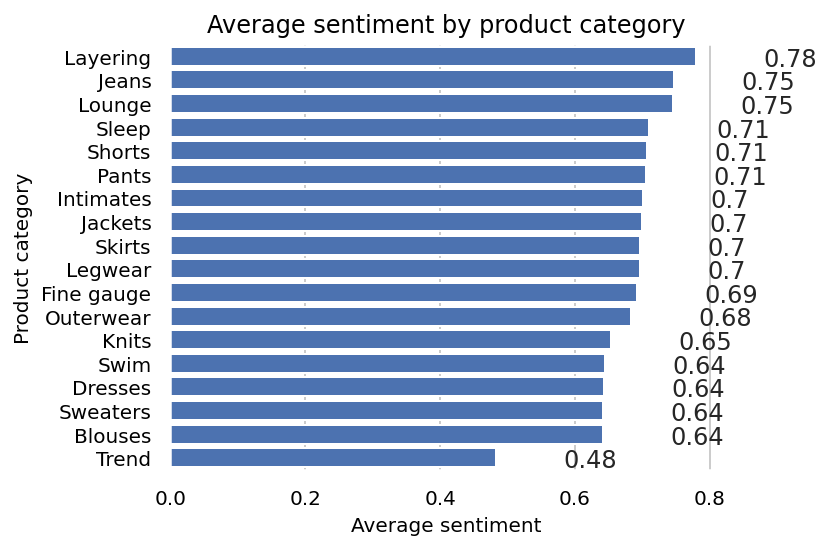

In [36]:
# Create plot
barplot = sns.barplot(
    data = df_avg_by_category, 
    y='product_category',
    x='avg_sentiment', 
    color="b", 
    saturation=1
)

# Set the size of the figure
sns.set(rc={'figure.figsize':(15.0, 10.0)})
    
# Set title and x-axis ticks 
plt.title('Average sentiment by product category')
#plt.xticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])

# Helper code to show actual values afters bars 
show_values_barplot(barplot, 0.1)

plt.xlabel("Average sentiment")
plt.ylabel("Product category")

plt.tight_layout()
# Do not change the figure name - it is used for grading purposes!
plt.savefig('images/avg_sentiment_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

In [37]:
# Upload image to S3 bucket
sess.upload_data(path='images/avg_sentiment_per_category.png', bucket=bucket, key_prefix="images")

's3://sagemaker-eu-north-1-295482097746/images/avg_sentiment_per_category.png'

Review the bucket on the account.


- if you click on the image name, you can see the information about the image file. You can also download the file with the command on the top right Object Actions -> Download / Download as

In [38]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/home?region={}">Amazon S3 buckets</a></b>'.format(region)))

<a name='c1w1-3.4.'></a>
### 3.4. Which product categories have the most reviews?

Set the SQL statement to find the count of sentiment per product category, showing the results in the descending order:

In [39]:
statement_count_by_category_desc = """
SELECT product_category, COUNT(*) AS count_reviews 
FROM {}
GROUP BY product_category 
ORDER BY count_reviews DESC
""".format(table_name)

print(statement_count_by_category_desc)


SELECT product_category, COUNT(*) AS count_reviews 
FROM reviews
GROUP BY product_category 
ORDER BY count_reviews DESC



Query data in Amazon Athena database passing the prepared SQL statement:

In [40]:
%%time
df_count_by_category_desc = wr.athena.read_sql_query(
    sql=statement_count_by_category_desc,
    database=database_name
)

CPU times: user 239 ms, sys: 12.9 ms, total: 252 ms
Wall time: 3.28 s


Store maximum number of sentiment for the visualization plot:

In [41]:
max_sentiment = df_count_by_category_desc['count_reviews'].max()
print('Highest number of reviews (in a single category): {}'.format(max_sentiment))

Highest number of reviews (in a single category): 6145


**Visualization**


Use `barplot` function to plot number of reviews per product category.


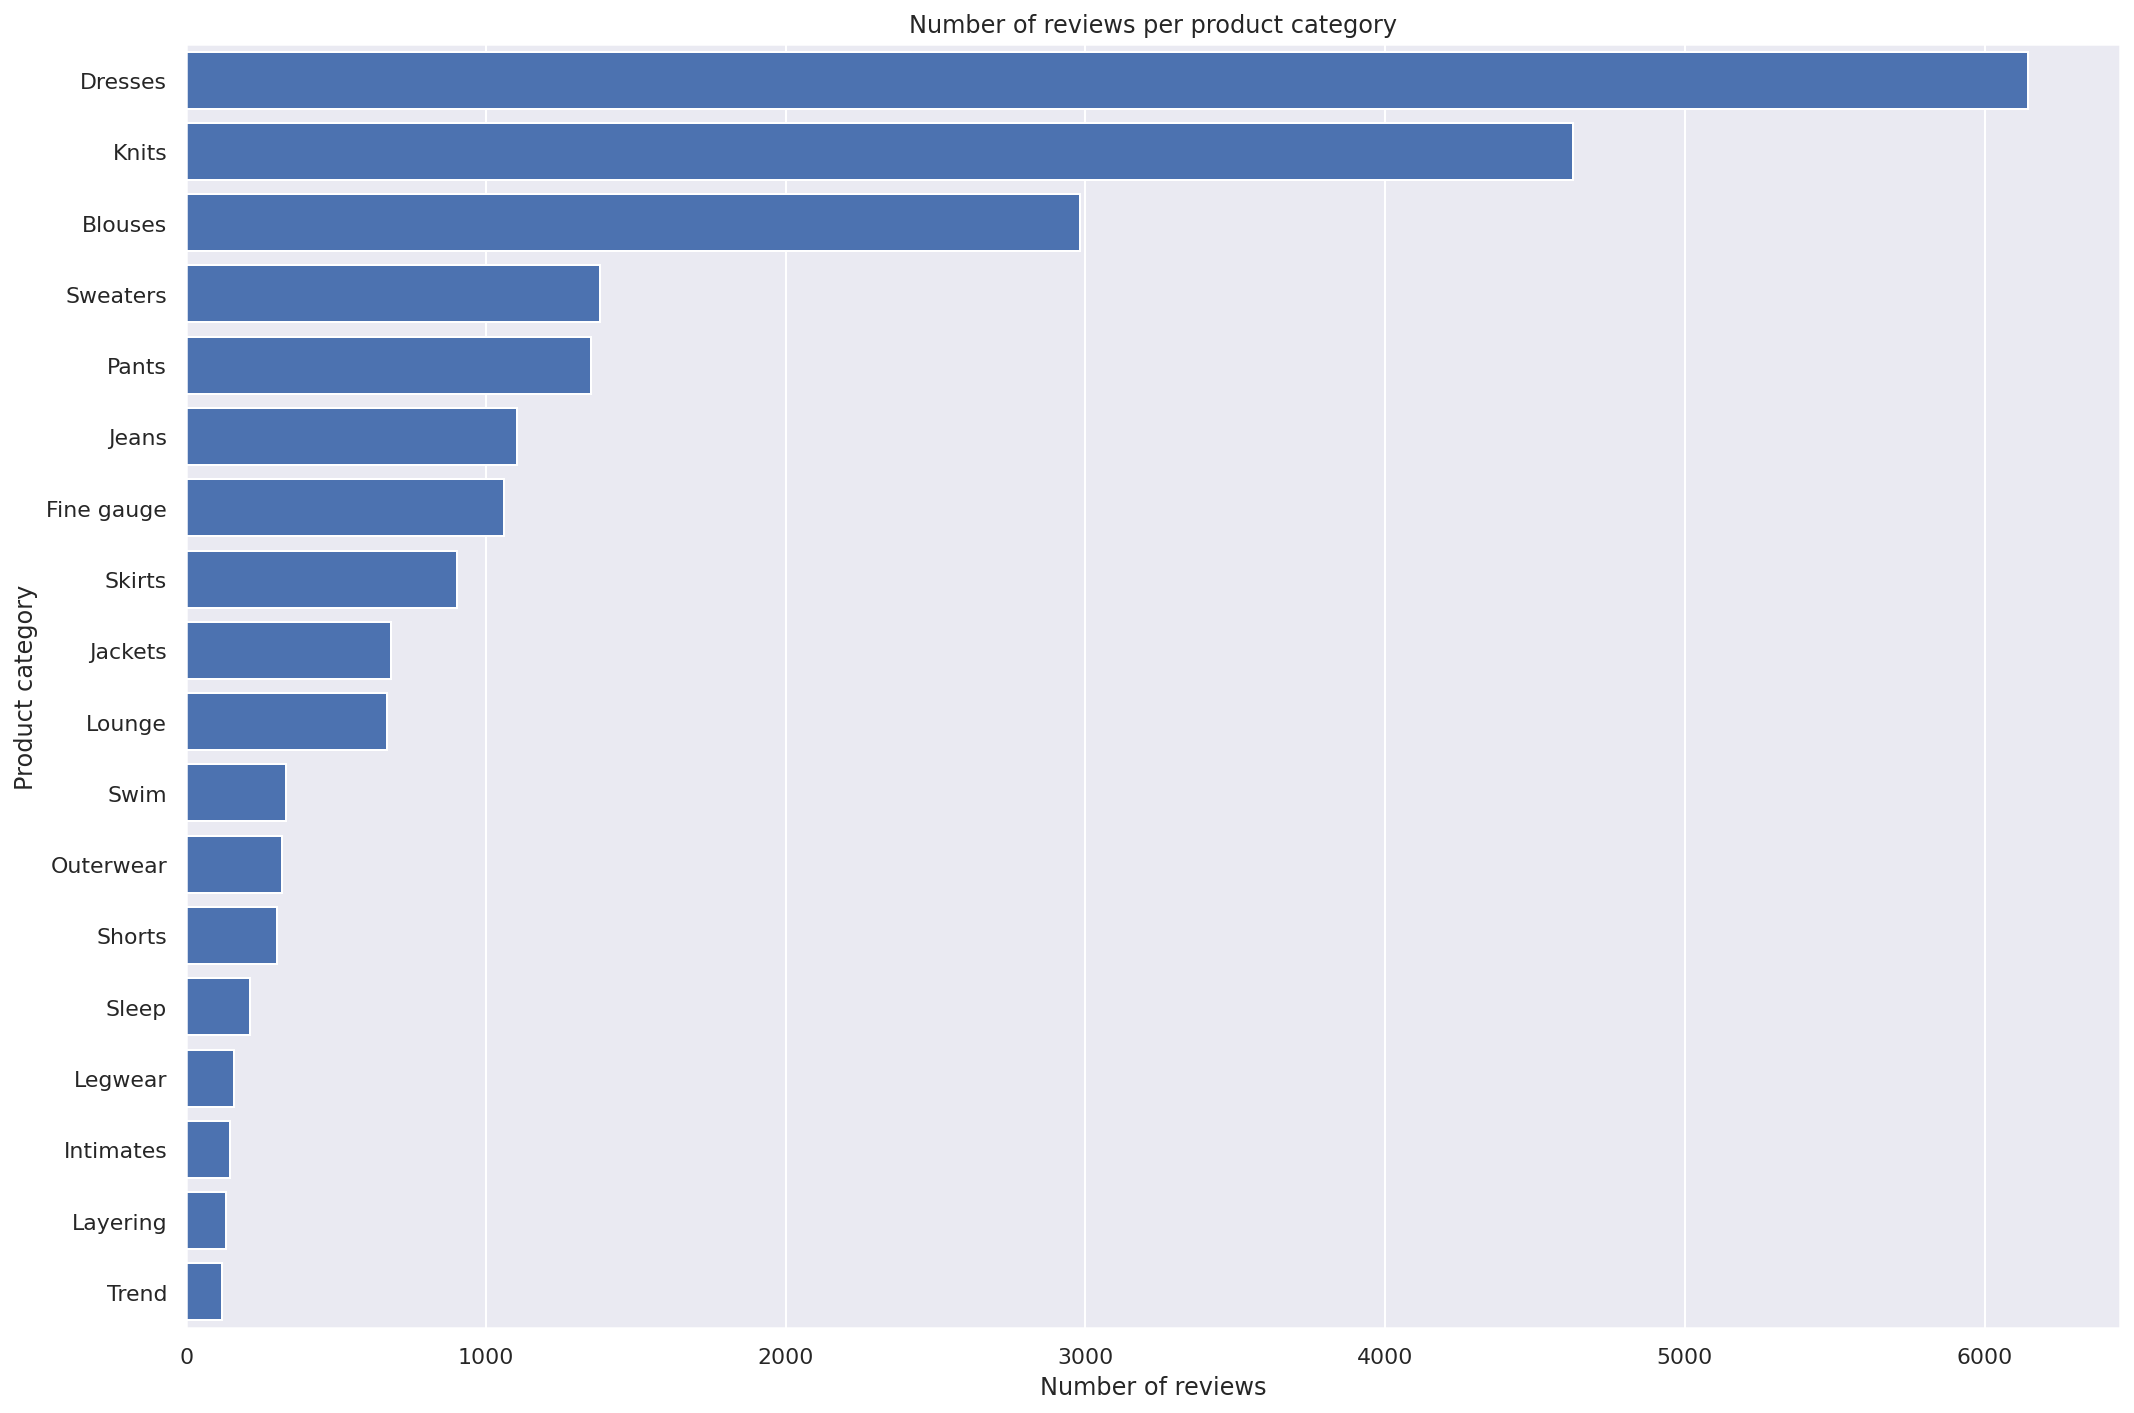

In [42]:
# Create seaborn barplot
barplot = sns.barplot(
    data=df_count_by_category_desc, #
    y='product_category', #
    x='count_reviews', #
    color="b",
    saturation=1
)

# Set the size of the figure
sns.set(rc={'figure.figsize':(15.0, 10.0)})
    
# Set title
plt.title("Number of reviews per product category")
plt.xlabel("Number of reviews")
plt.ylabel("Product category")

plt.tight_layout()

# Do not change the figure name - it is used for grading purposes!
plt.savefig('images/num_reviews_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

In [43]:
# Upload image to S3 bucket
sess.upload_data(path='images/num_reviews_per_category.png', bucket=bucket, key_prefix="images")

's3://sagemaker-eu-north-1-295482097746/images/num_reviews_per_category.png'

<a name='c1w1-3.5.'></a>
### 3.5. What is the breakdown of sentiments per product category?

Set the SQL statement to find the count of sentiment per product category and sentiment:

In [44]:
statement_count_by_category_and_sentiment = """
SELECT product_category,
         sentiment,
         COUNT(*) AS count_reviews
FROM {}
GROUP BY  product_category, sentiment
ORDER BY  product_category ASC, sentiment DESC, count_reviews
""".format(table_name)

print(statement_count_by_category_and_sentiment)


SELECT product_category,
         sentiment,
         COUNT(*) AS count_reviews
FROM reviews
GROUP BY  product_category, sentiment
ORDER BY  product_category ASC, sentiment DESC, count_reviews



Query data in Amazon Athena database passing the prepared SQL statement:

In [45]:
%%time
df_count_by_category_and_sentiment = wr.athena.read_sql_query(
    sql=statement_count_by_category_and_sentiment,
    database=database_name
)

CPU times: user 244 ms, sys: 6.69 ms, total: 250 ms
Wall time: 3.46 s


Prepare for stacked percentage horizontal bar plot showing proportion of sentiments per product category.

In [46]:
# Create grouped dataframes by category and by sentiment
grouped_category = df_count_by_category_and_sentiment.groupby('product_category')
grouped_star = df_count_by_category_and_sentiment.groupby('sentiment')

# Create sum of sentiments per star sentiment
df_sum = df_count_by_category_and_sentiment.groupby(['sentiment']).sum()

# Calculate total number of sentiments
total = df_sum['count_reviews'].sum()
print('Total number of reviews: {}'.format(total))

Total number of reviews: 22626


Create dictionary of product categories and array of star rating distribution per category.

In [47]:
distribution = {}
count_reviews_per_star = []
i=0

for category, sentiments in grouped_category:
    count_reviews_per_star = []
    for star in sentiments['sentiment']:
        count_reviews_per_star.append(sentiments.at[i, 'count_reviews'])
        i=i+1;
    distribution[category] = count_reviews_per_star

Build array per star across all categories.

In [48]:
distribution

{'Blouses': [2256, 384, 343],
 'Dresses': [4634, 830, 681],
 'Fine gauge': [837, 118, 104],
 'Intimates': [117, 16, 14],
 'Jackets': [550, 61, 72],
 'Jeans': [909, 110, 85],
 'Knits': [3523, 605, 498],
 'Layering': [113, 9, 10],
 'Legwear': [126, 16, 16],
 'Lounge': [545, 78, 46],
 'Outerwear': [254, 29, 36],
 'Pants': [1074, 154, 122],
 'Shorts': [240, 39, 25],
 'Skirts': [714, 104, 85],
 'Sleep': [175, 16, 23],
 'Sweaters': [1036, 193, 151],
 'Swim': [252, 42, 38],
 'Trend': [78, 19, 21]}

In [49]:
df_distribution_pct = pd.DataFrame(distribution).transpose().apply(
    lambda num_sentiments: num_sentiments/sum(num_sentiments)*100, axis=1
)
df_distribution_pct.columns=['1', '0', '-1']
df_distribution_pct

,1,0,-1
Blouses,75.628562,12.872947,11.498491
Dresses,75.410903,13.506916,11.082181
Fine gauge,79.036827,11.142587,9.820585
Intimates,79.591837,10.884354,9.523810
Jackets,80.527086,8.931186,10.541728
Jeans,82.336957,9.963768,7.699275
Knits,76.156507,13.078253,10.765240
Layering,85.606061,6.818182,7.575758
Legwear,79.746835,10.126582,10.126582
Lounge,81.464873,11.659193,6.875934


**Visualization**

Plot the distributions of sentiments per product category.

<Figure size 720x360 with 0 Axes>

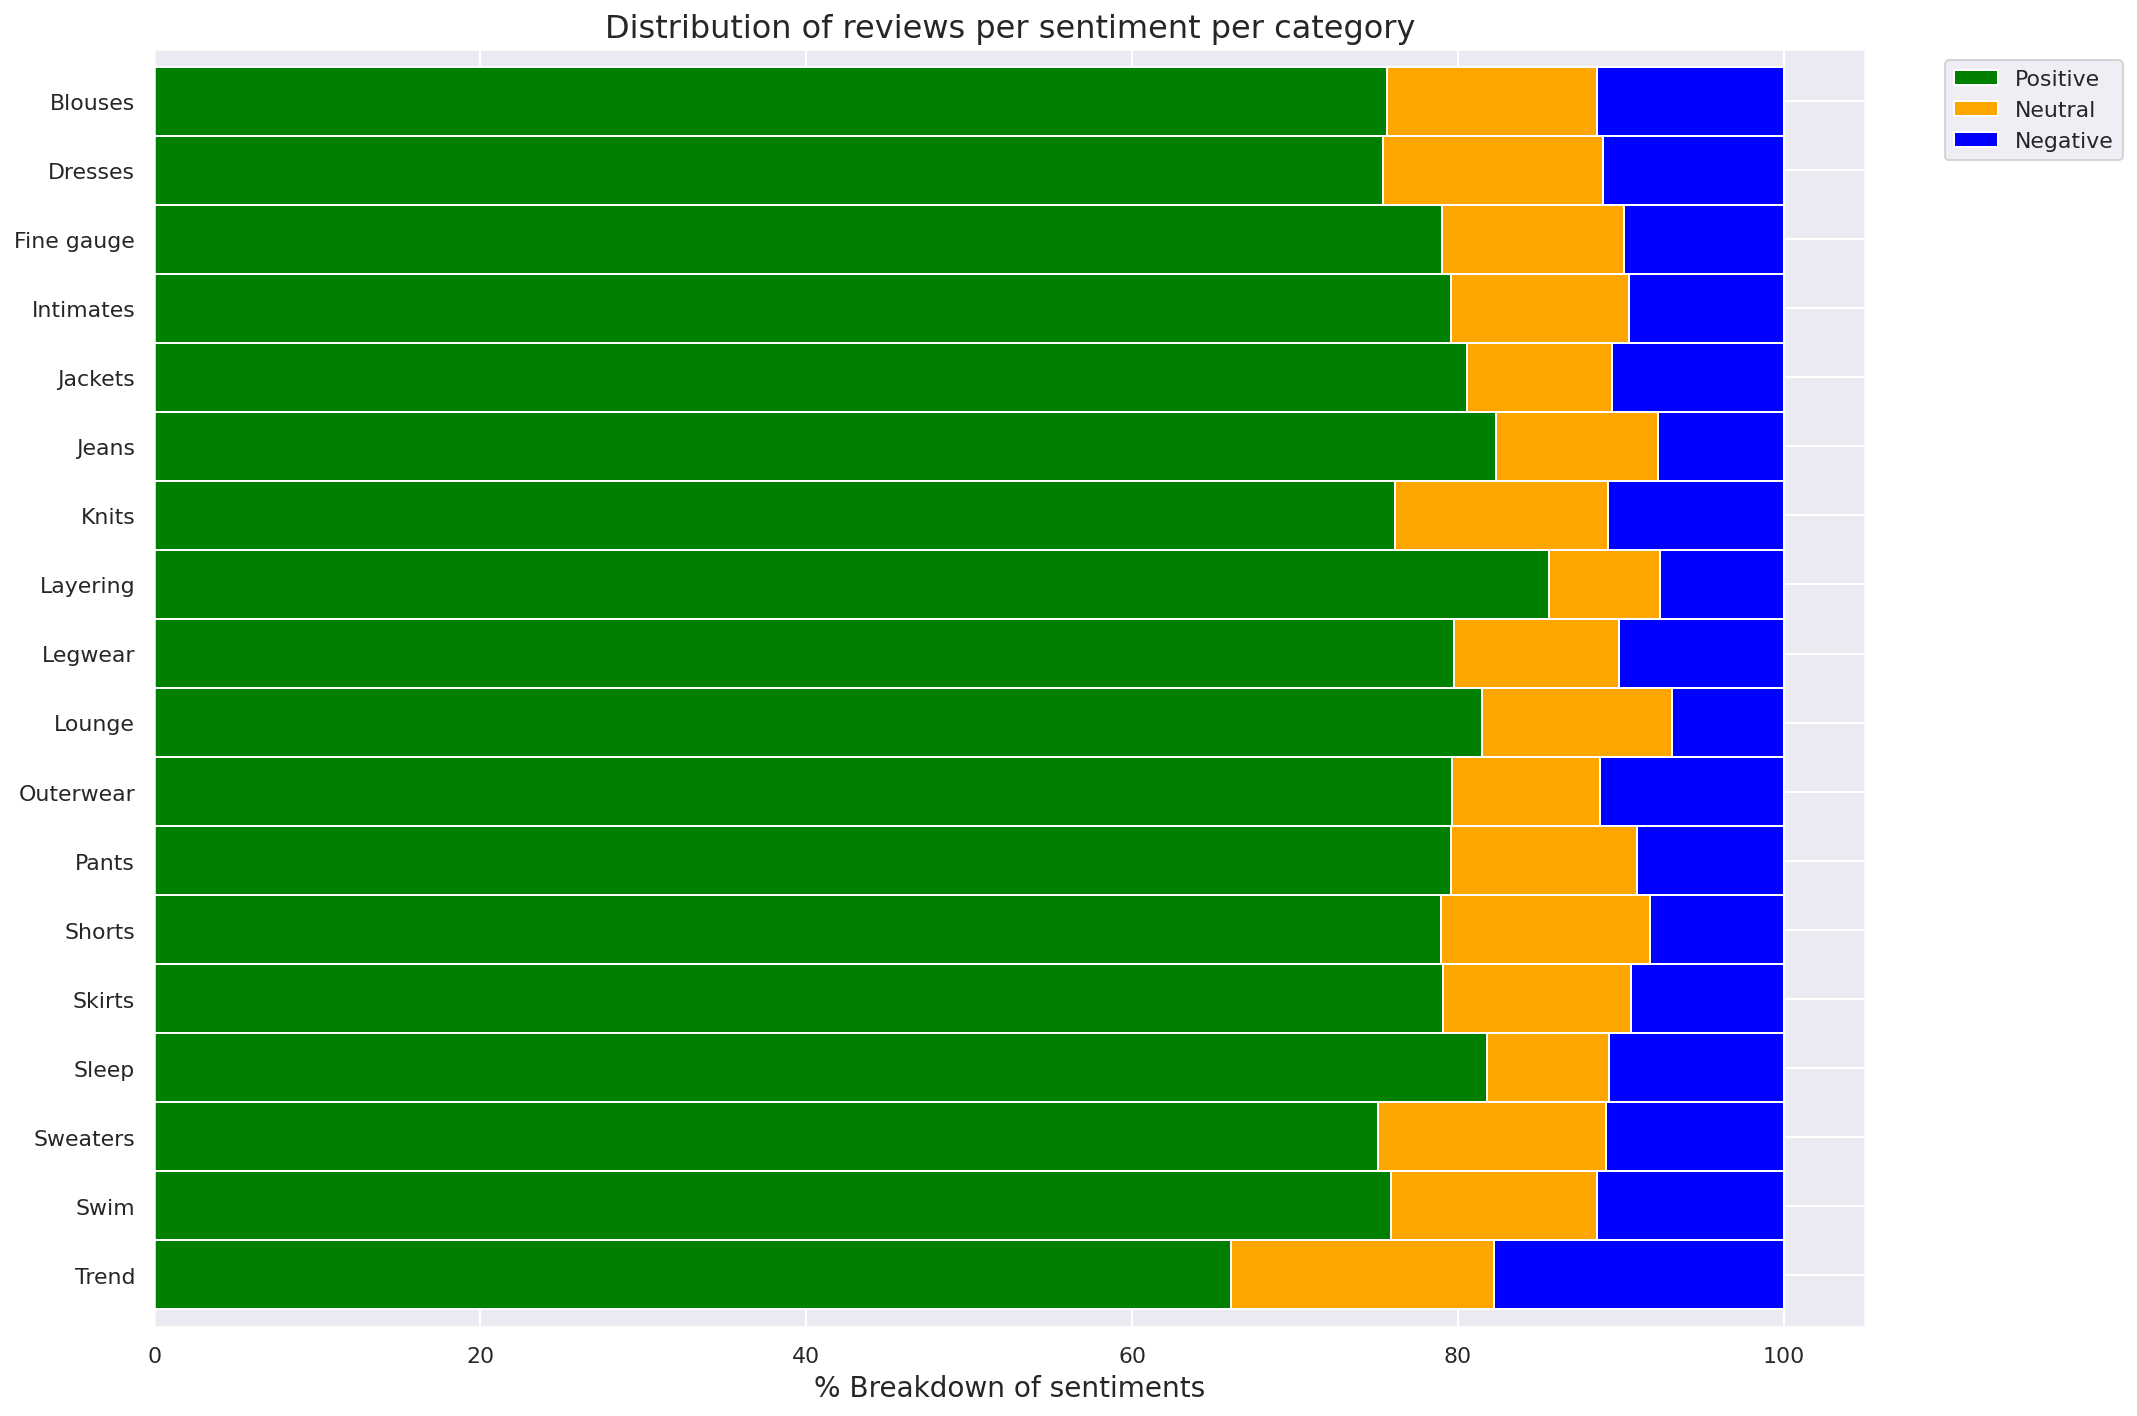

In [50]:
categories = df_distribution_pct.index

# Plot bars
plt.figure(figsize=(10,5))

df_distribution_pct.plot(kind="barh", 
                         stacked=True, 
                         edgecolor='white',
                         width=1.0,
                         color=['green', 
                                'orange', 
                                'blue'])

plt.title("Distribution of reviews per sentiment per category", 
          fontsize='16')

plt.legend(bbox_to_anchor=(1.04,1), 
           loc="upper left",
           labels=['Positive', 
                   'Neutral', 
                   'Negative'])

plt.xlabel("% Breakdown of sentiments", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

# Do not change the figure name - it is used for grading purposes!
plt.savefig('images/distribution_sentiment_per_category.png', dpi=300)
plt.show()

In [51]:
# Upload image to S3 bucket
sess.upload_data(path='images/distribution_sentiment_per_category.png', bucket=bucket, key_prefix="images")

's3://sagemaker-eu-north-1-295482097746/images/distribution_sentiment_per_category.png'

<a name='c1w1-3.6.'></a>
### 3.6. Analyze the distribution of review word counts

Set the SQL statement to count the number of the words in each of the reviews:

In [52]:
statement_num_words = """
    SELECT CARDINALITY(SPLIT(review_body, ' ')) as num_words
    FROM {}
""".format(table_name)

print(statement_num_words)


    SELECT CARDINALITY(SPLIT(review_body, ' ')) as num_words
    FROM reviews



Query data in Amazon Athena database passing the SQL statement:

In [53]:
%%time
df_num_words = wr.athena.read_sql_query(
    sql=statement_num_words,
    database=database_name
)

CPU times: user 253 ms, sys: 7.79 ms, total: 260 ms
Wall time: 3.38 s


Print out and analyse some descriptive statistics: 

In [54]:
summary = df_num_words["num_words"].describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
summary

count    22626.000000
mean        62.709847
std         29.993735
min          2.000000
10%         22.000000
20%         33.000000
30%         42.000000
40%         51.000000
50%         61.000000
60%         72.000000
70%         86.000000
80%         97.000000
90%        103.000000
100%       122.000000
max        122.000000
Name: num_words, dtype: float64

Plot the distribution of the words number per review:

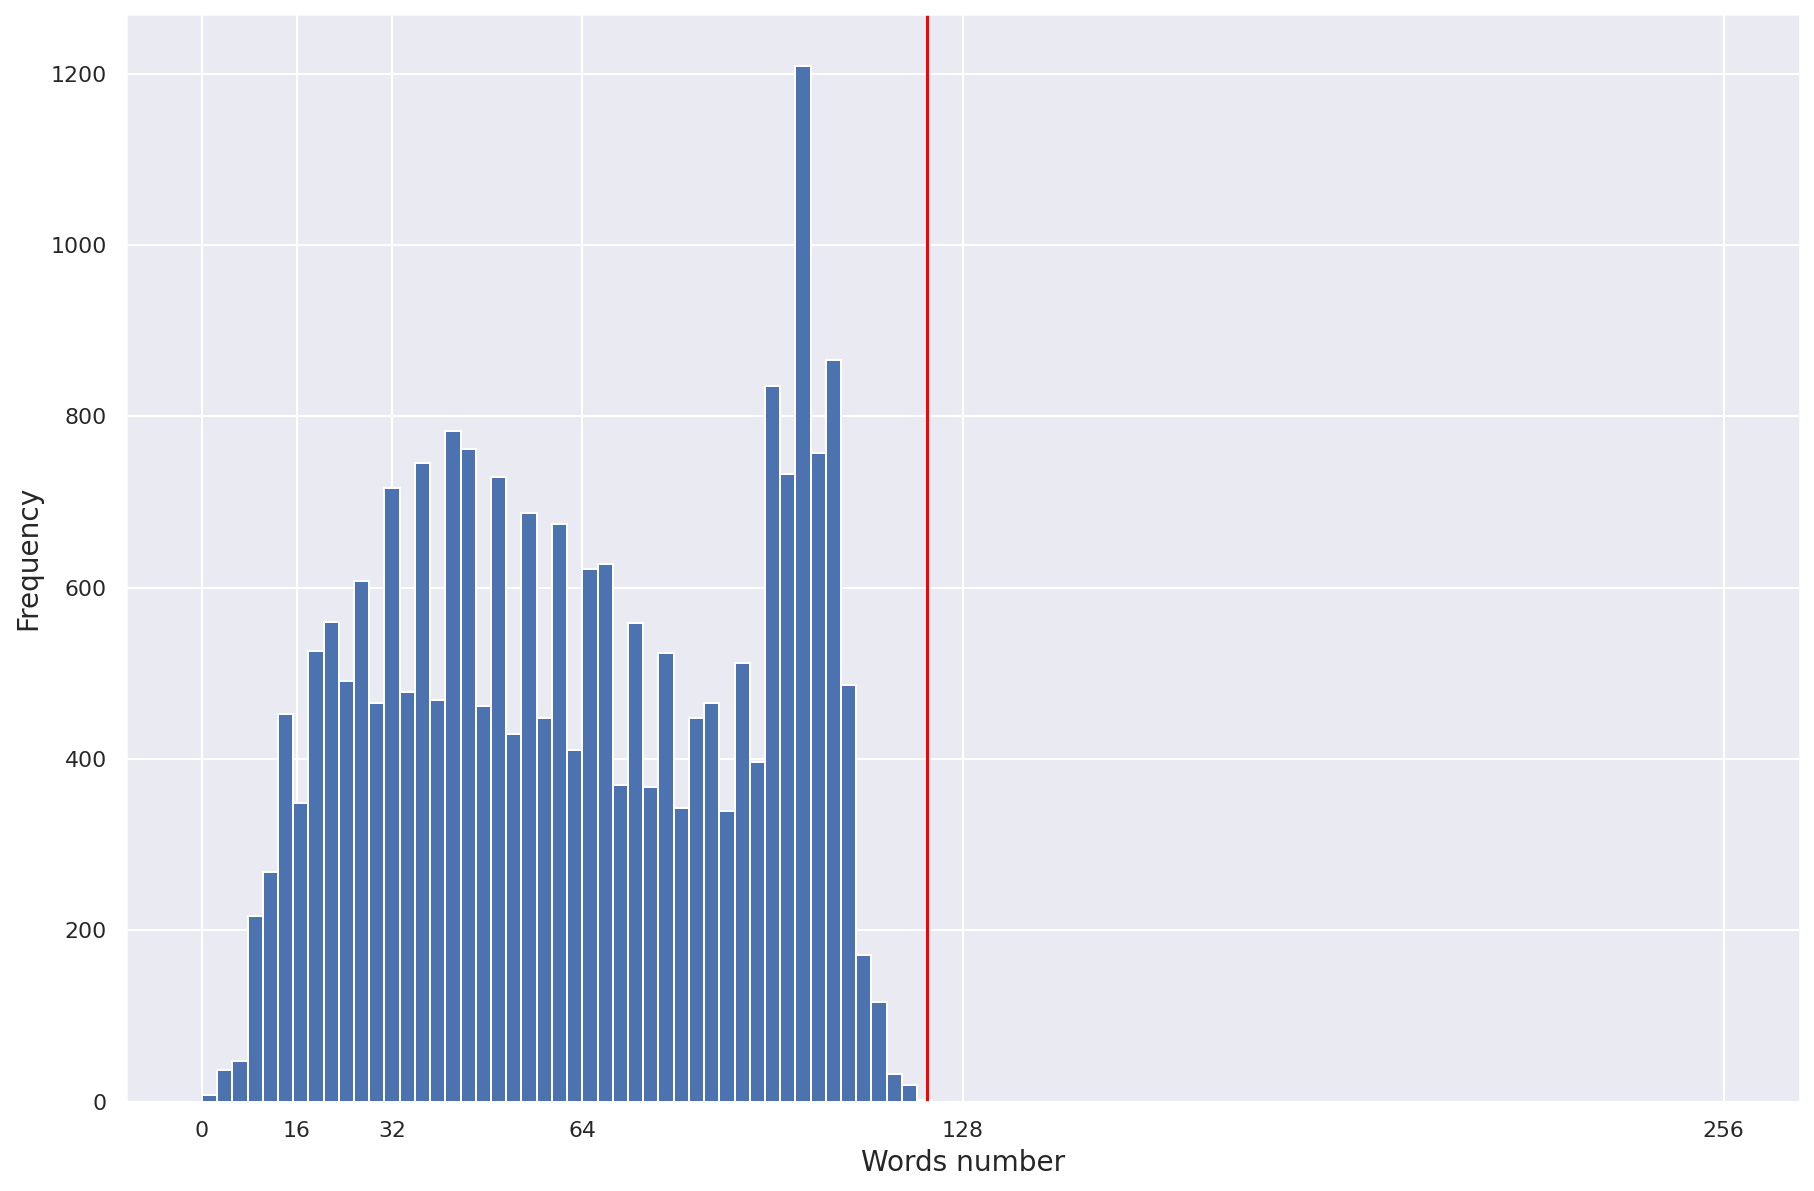

In [55]:
df_num_words["num_words"].plot.hist(xticks=[0, 16, 32, 64, 128, 256], bins=100, range=[0, 256]).axvline(
    x=summary["100%"], c="red"
)

plt.xlabel("Words number", fontsize='14')
plt.ylabel("Frequency", fontsize='14')
plt.savefig('images/distribution_num_words_per_review.png', dpi=300)
plt.show()

In [56]:
# Upload image to S3 bucket
sess.upload_data(path='images/distribution_num_words_per_review.png', bucket=bucket, key_prefix="images")

's3://sagemaker-eu-north-1-295482097746/images/distribution_num_words_per_review.png'

As you have seen, there are way more positive reviews than negative or neutral. Such a dataset is called unbalanced.

In this case, using a relatively small data subset you could visualize the occurring unbalances. At scale, you would need to perform bias analysis. Let's use this dataset as an example.

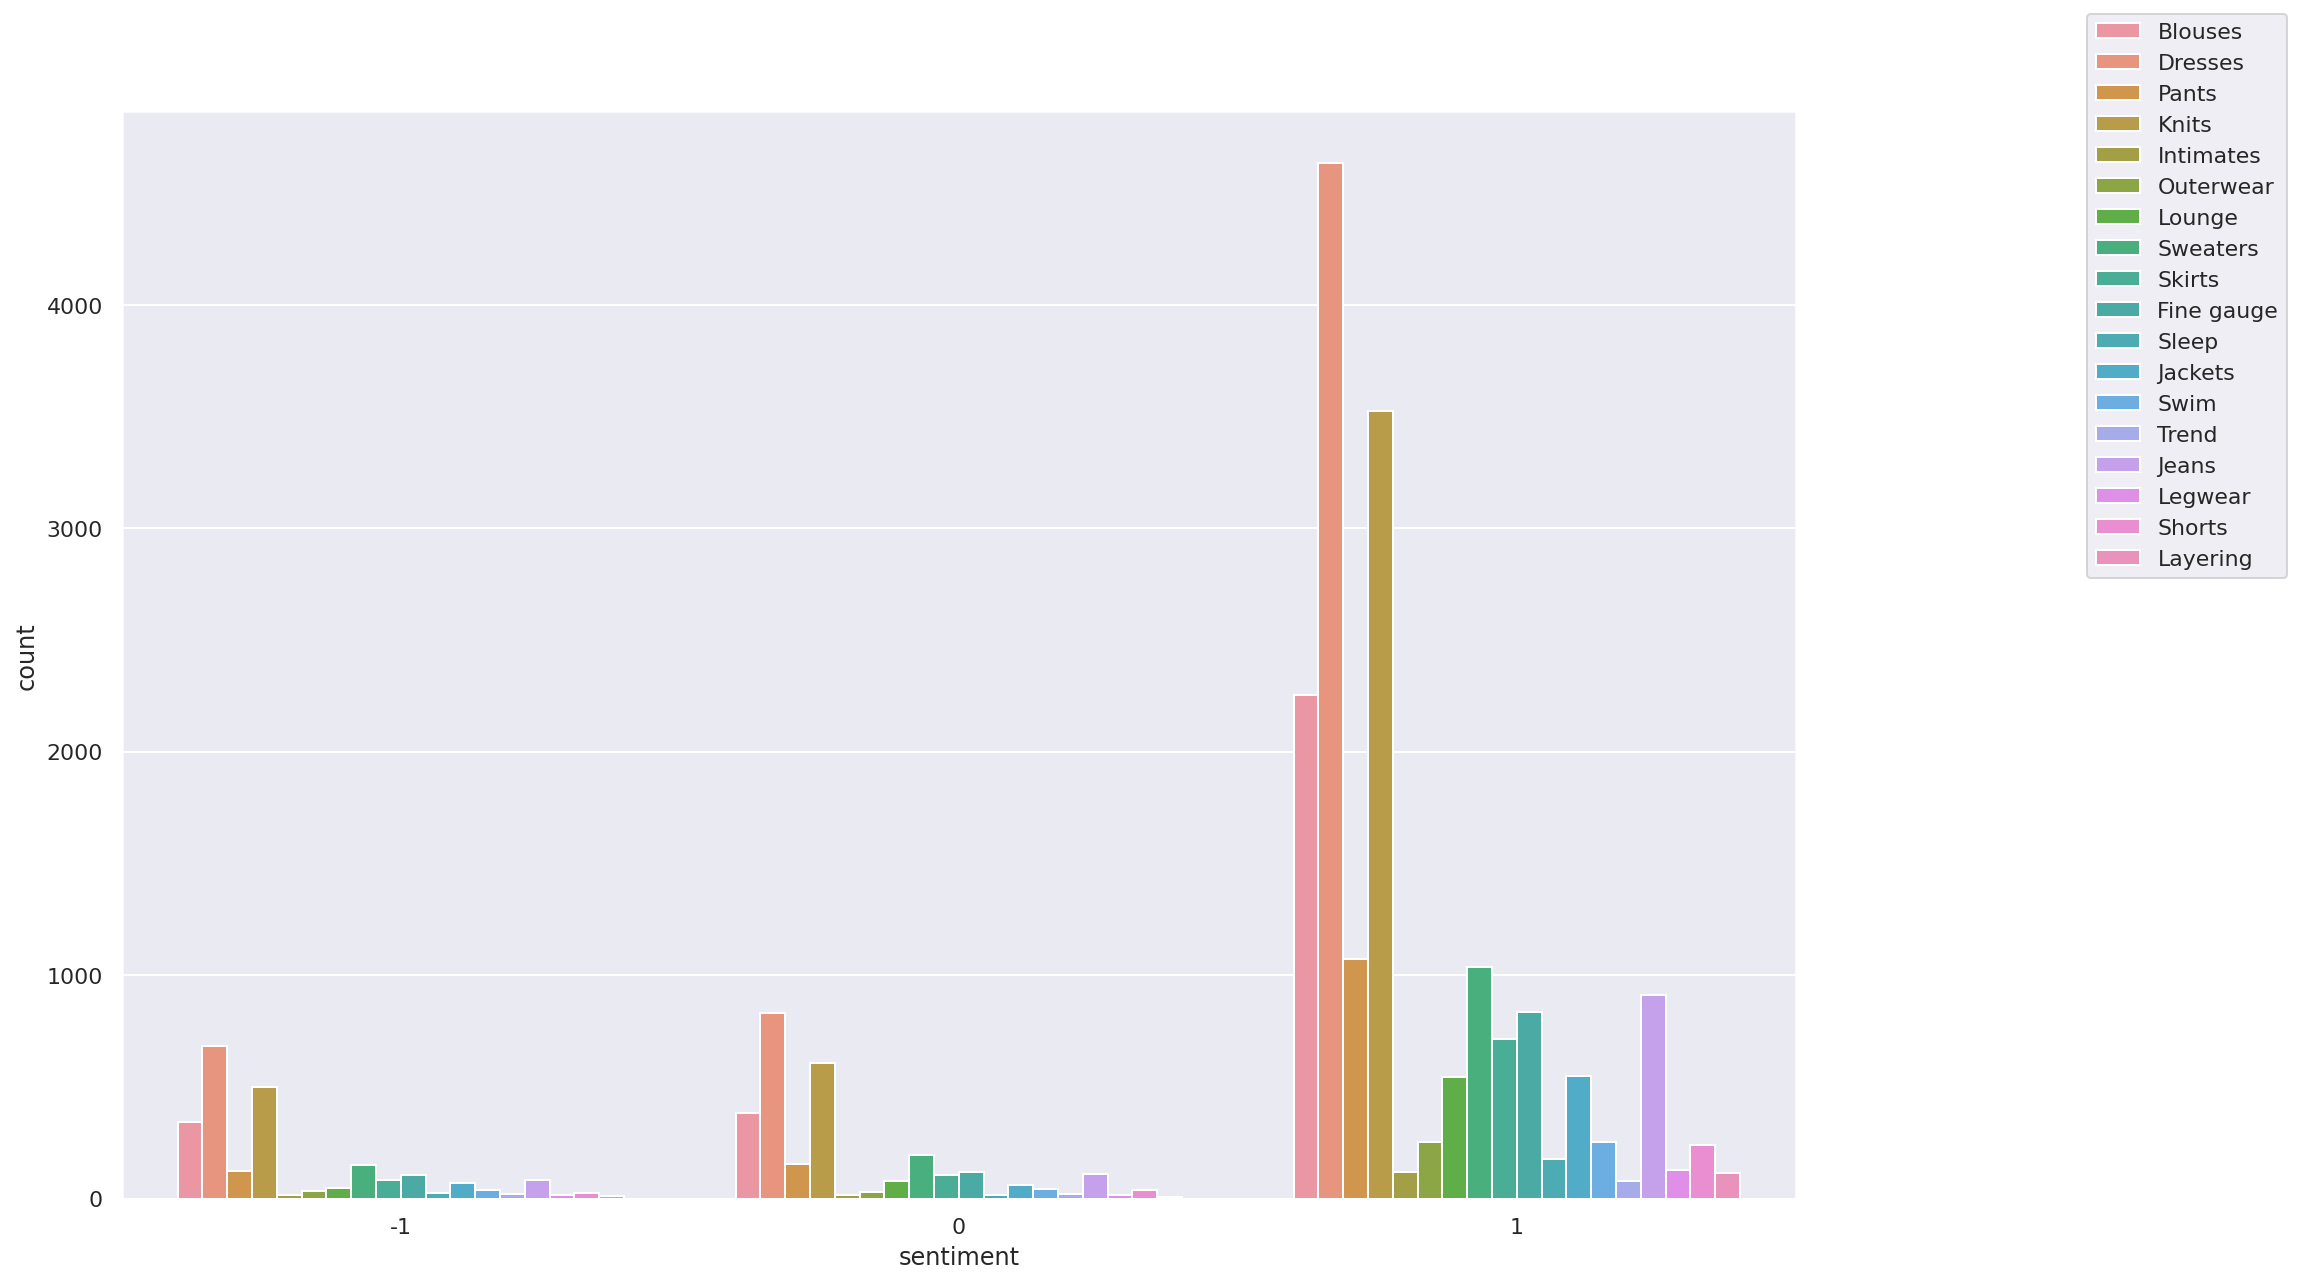

In [58]:
sns.countplot(data=df_transformed, x='sentiment', hue='product_category')

plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1.1))

Upload the dataset to a private S3 bucket in a folder called `data/bias/unbalanced`.

In [61]:
data_s3_uri_unbalanced = sess.upload_data(bucket=bucket, 
                               key_prefix='data/bias/unbalanced', 
                               path='./data/transformed/womens_clothing_ecommerce_reviews_transformed.csv')
data_s3_uri_unbalanced

's3://sagemaker-eu-north-1-295482097746/data/bias/unbalanced/womens_clothing_ecommerce_reviews_transformed.csv'

<a name='c1w2-2.'></a>
# 4. Analyze class imbalance on the dataset with Amazon SageMaker Clarify
Let's analyze bias in `sentiment` with respect to the `product_category` facet on the dataset.

<a name='c1w2-2.1.'></a>
### 4.1. Configure a `DataConfig`

Information about the input data needs to be provided to the processor. This can be done with the `DataConfig` of the Clarify container. It stores information about the dataset to be analyzed, for example the dataset file, its format, headers and labels.


Configure a `DataConfig` for Clarify.

In [76]:
from sagemaker import clarify

bias_report_unbalanced_output_path = 's3://{}/data/bias/generated_bias_report/unbalanced'.format(bucket)

data_config_unbalanced = clarify.DataConfig(
    s3_data_input_path=data_s3_uri_unbalanced,
    s3_output_path=bias_report_unbalanced_output_path,
    label='sentiment',
    headers=df_transformed.columns.to_list(),
    dataset_type='text/csv'
)

<a name='c1w2-2.2.'></a>
### 4.2. Configure `BiasConfig`
Bias is measured by calculating a metric and comparing it across groups. To compute it, you will specify the required information in the `BiasConfig` API. SageMaker Clarify needs the sensitive columns (`facet_name`) and the desirable outcomes (`label_values_or_threshold`). Here `product_category` is the sensitive facet and the desired outcome is with the `sentiment==1`.


SageMaker Clarify can handle both categorical and continuous data for `label_values_or_threshold`. In this case you are using categorical data.

In [77]:
bias_config_unbalanced = clarify.BiasConfig(
    label_values_or_threshold=[1], # desired sentiment
    facet_name='product_category' # sensitive column (facet)
)

<a name='c1w2-2.3.'></a>
### 4.3. Configure Amazon SageMaker Clarify as a processing job

In [78]:
clarify_processor_unbalanced = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.m5.large',
                                                      sagemaker_session=sess)

<a name='c1w2-2.4.'></a>
### 4.4. Run the Amazon SageMaker Clarify processing job

In [79]:
clarify_processor_unbalanced.run_pre_training_bias(
    data_config=data_config_unbalanced,
    data_bias_config=bias_config_unbalanced,
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False,
    logs=False
)


Job Name:  Clarify-Pretraining-Bias-2021-08-03-07-25-43-693
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-north-1-295482097746/data/bias/unbalanced/womens_clothing_ecommerce_reviews_transformed.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-north-1-295482097746/data/bias/generated_bias_report/unbalanced/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-eu-north-1-295482097746/data/bias/generated_bias_report/unbalanced', 'LocalPath': '/opt/ml/processing/output', 'S3Upload

In [80]:
run_unbalanced_bias_processing_job_name = clarify_processor_unbalanced.latest_job.job_name
print(run_unbalanced_bias_processing_job_name)

Clarify-Pretraining-Bias-2021-08-03-07-25-43-693


<a name='c1w2-2.5.'></a>
### 4.5. Run and review the Amazon SageMaker Clarify processing job on the unbalanced dataset

Review the created Amazon SageMaker Clarify processing job and the Cloud Watch logs.

In [81]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">processing job</a></b>'.format(region, run_unbalanced_bias_processing_job_name)))


In [82]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, run_unbalanced_bias_processing_job_name)))

In [83]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(processing_job_name=run_unbalanced_bias_processing_job_name,
                                                                            sagemaker_session=sess)

In [84]:
%%time

running_processor.wait(logs=False)

..............................................................!CPU times: user 260 ms, sys: 15 ms, total: 275 ms
Wall time: 5min 11s


<a name='c1w2-2.6.'></a>
### 4.6. Analyze unbalanced bias report
In this run, you analyzed bias for `sentiment` relative to the `product_category` for the unbalanced data. Let's have a look at the bias report.

In [85]:
!aws s3 ls $bias_report_unbalanced_output_path/

2021-08-03 07:30:55      31732 analysis.json
2021-08-03 07:25:44        346 analysis_config.json
2021-08-03 07:30:55     386950 report.html
2021-08-03 07:30:55     121999 report.ipynb
2021-08-03 07:30:55     139371 report.pdf


In [86]:
!aws s3 cp --recursive $bias_report_unbalanced_output_path ./data/generated_bias_report/unbalanced/

download: s3://sagemaker-eu-north-1-295482097746/data/bias/generated_bias_report/unbalanced/analysis_config.json to data/generated_bias_report/unbalanced/analysis_config.json
download: s3://sagemaker-eu-north-1-295482097746/data/bias/generated_bias_report/unbalanced/analysis.json to data/generated_bias_report/unbalanced/analysis.json
download: s3://sagemaker-eu-north-1-295482097746/data/bias/generated_bias_report/unbalanced/report.ipynb to data/generated_bias_report/unbalanced/report.ipynb
download: s3://sagemaker-eu-north-1-295482097746/data/bias/generated_bias_report/unbalanced/report.pdf to data/generated_bias_report/unbalanced/report.pdf
download: s3://sagemaker-eu-north-1-295482097746/data/bias/generated_bias_report/unbalanced/report.html to data/generated_bias_report/unbalanced/report.html


In [88]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./data/generated_bias_report/unbalanced/report.html">unbalanced bias report</a></b>'))

The bias report shows a number of metrics, but here you can focus on just two of them: 
- Class Imbalance (CI). Measures the imbalance in the number of members between different facet values. Answers the question, does a `product_category` have disproportionately more reviews than others? Values of CI will become equal for even distribution between facets. Here, different CI values show the existence of imbalance.
- Difference in Positive Proportions in Labels (DPL). Measures the imbalance of positive outcomes between different facet values. Answers the question, does a `product_category` have disproportionately higher ratings than others? With the range over the interval from -1 to 1, if there is no bias, you want to see this value as close as possible to zero. Here, non-zero values indicate the imbalances.

<a name='c1w2-3.'></a>
# 5. Balance the dataset by `product_category` and `sentiment`
Let's balance the dataset by `product_category` and `sentiment`. Then you can configure and run SageMaker Clarify processing job to analyze the bias of it.

In [89]:
df_grouped_by = df_transformed.groupby(['product_category', 'sentiment'])
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

In [90]:
df_balanced

sentiment  \
product_category sentiment                
Blouses          -1        0         -1   
                           1         -1   
                           2         -1   
                           3         -1   
                           4         -1   
...                                 ...   
Trend             1        4          1   
                           5          1   
                           6          1   
                           7          1   
                           8          1   

                                                                    review_body  \
product_category sentiment                                                        
Blouses          -1        0  The neckline is very tight and itchy. the arm ...   
                           1  I was so excited to receive this top!!! the ma...   
                           2  Color is not like photo and fit doesn't work i...   
                           3  Runs large. very boxy. white fabric on lower p...   
                           4  This piece didn't make sense to me.  maybe it'...   
...                                                                         ...   
Trend             1        4  This dress is much larger in person than it lo...   
                           5  So different than anything in my closet. it's ...   
                           6  I love his cardigan! i knew the small would be...   
                           7  I saw this online yesterday and i was in the s...   
                           8  This dress us high quality and feels great  ho...   

                             product_category  
product_category sentiment                     
Blouses          -1        0          Blouses  
                           1          Blouses  
                           2          Blouses  
                           3          Blouses  
                           4          Blouses  
...                                       ...  
Trend             1        4            Trend  
                           5            Trend  
                           6            Trend  
                           7            Trend  
                           8            Trend  

[486 rows x 3 columns]

Visualize the distribution of review sentiment in the balanced dataset.

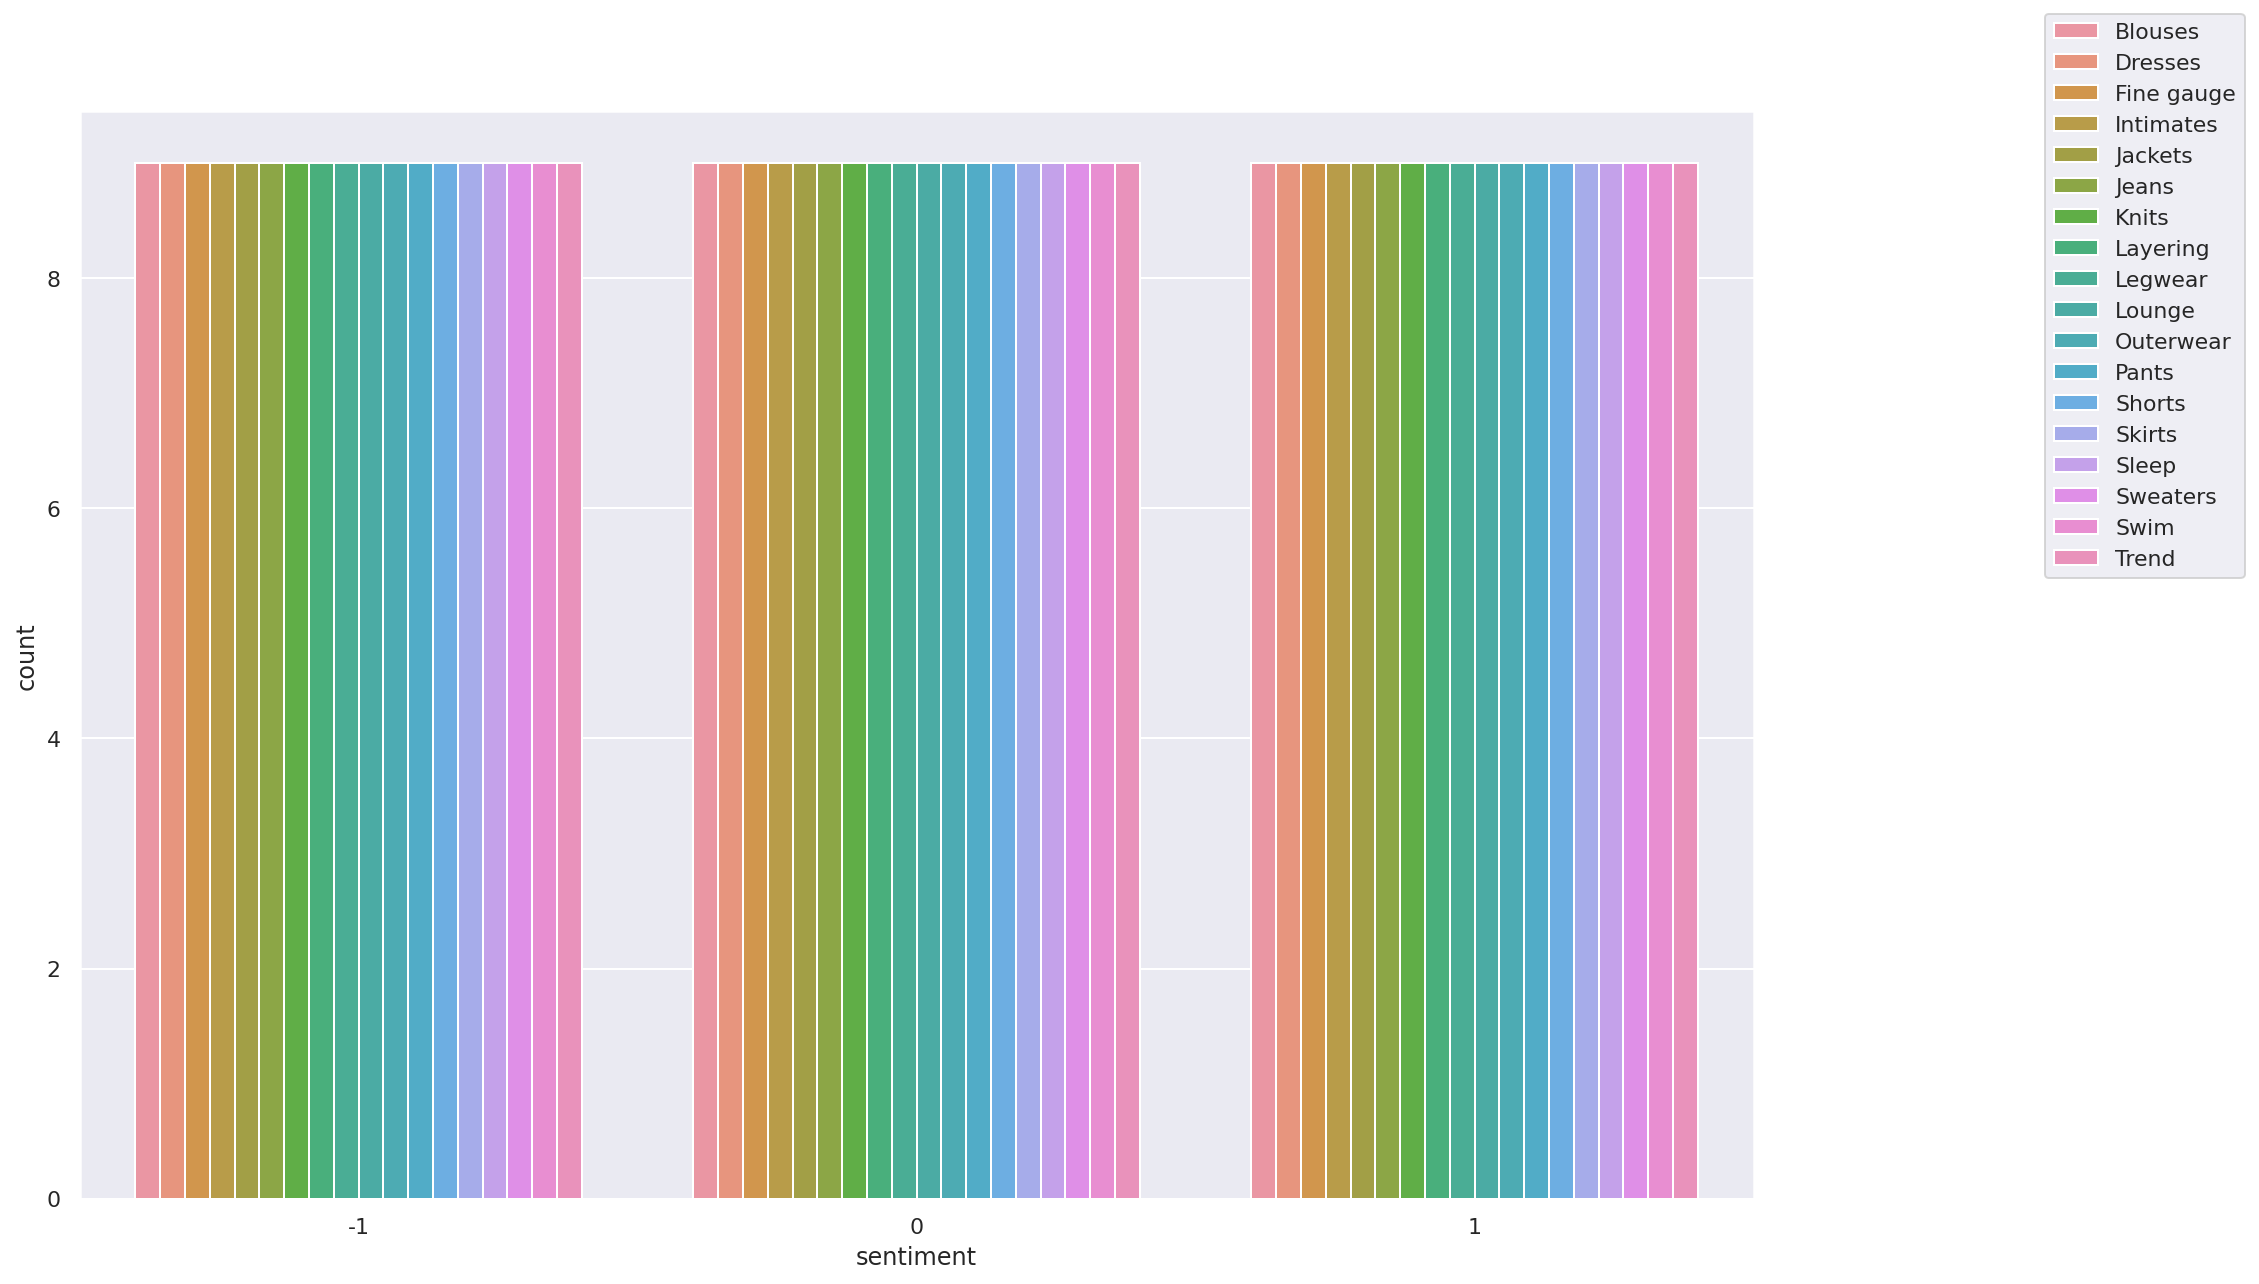

In [91]:
sns.countplot(data=df_balanced, x='sentiment', hue='product_category')

plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1.1))

<a name='c1w2-4.'></a>
# 6. Analyze bias on balanced dataset with Amazon SageMaker Clarify
Let's analyze bias in `sentiment` with respect to the `product_category` facet on your balanced dataset.

In [93]:
path_balanced = './data/transformed/womens_clothing_ecommerce_reviews_balanced.csv'
df_balanced.to_csv(path_balanced, index=False, header=True)

data_s3_uri_balanced = sess.upload_data(bucket=bucket, key_prefix='data/bias/balanced', path=path_balanced)
data_s3_uri_balanced

's3://sagemaker-eu-north-1-295482097746/data/bias/balanced/womens_clothing_ecommerce_reviews_balanced.csv'

You can review the uploaded CSV file in the S3 bucket and prefix `data/bias/balanced`.

In [94]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/home?region={}#">Amazon S3 bucket</a></b>'.format(region)))

<a name='c1w2-4.1.'></a>
### 6.1. Configure a `DataConfig`

Configure a `DataConfig` for Clarify to analyze bias on the balanced dataset.

In [95]:
from sagemaker import clarify

bias_report_balanced_output_path = 's3://{}/data/bias/generated_bias_report/balanced'.format(bucket)

data_config_balanced = clarify.DataConfig(
    s3_data_input_path=data_s3_uri_balanced,
    s3_output_path=bias_report_balanced_output_path,
    label='sentiment',
    headers=df_balanced.columns.to_list(),
    dataset_type='text/csv'
)

<a name='c1w2-4.2.'></a>
### 6.2. Configure `BiasConfig`

`BiasConfig` for the balanced dataset will have the same settings as before.

In [96]:
bias_config_balanced = clarify.BiasConfig(
    label_values_or_threshold=[1], # desired sentiment
    facet_name='product_category' # sensitive column (facet)
)

<a name='c1w2-4.3.'></a>
### 6.3. Configure SageMaker Clarify as a processing job

`SageMakerClarifyProcessor` object will also have the same parameters.

In [97]:
clarify_processor_balanced = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.m5.large',
                                                      sagemaker_session=sess)

<a name='c1w2-4.4.'></a>
### 6.4. Run the Amazon SageMaker Clarify processing job

Run the configured processing job for the balanced dataset.

In [98]:
clarify_processor_balanced.run_pre_training_bias(
    data_config=data_config_balanced,
    data_bias_config=bias_config_balanced,
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False,
    logs=False
)


Job Name:  Clarify-Pretraining-Bias-2021-08-03-08-08-10-646
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-north-1-295482097746/data/bias/balanced/womens_clothing_ecommerce_reviews_balanced.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-north-1-295482097746/data/bias/generated_bias_report/balanced/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-eu-north-1-295482097746/data/bias/generated_bias_report/balanced', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'E

In [99]:
run_balanced_bias_processing_job_name = clarify_processor_balanced.latest_job.job_name
print(run_balanced_bias_processing_job_name)

Clarify-Pretraining-Bias-2021-08-03-08-08-10-646


In [100]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">processing job</a></b>'.format(region, run_balanced_bias_processing_job_name)))

In [101]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, run_balanced_bias_processing_job_name)))

In [102]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(processing_job_name=run_balanced_bias_processing_job_name,
                                                                            sagemaker_session=sess)

In [103]:
%%time

running_processor.wait(logs=False)

......!CPU times: user 37.6 ms, sys: 509 µs, total: 38.1 ms
Wall time: 30.2 s


<a name='c1w2-4.6.'></a>
### 6.6. Analyze balanced bias report

In [105]:
!aws s3 ls $bias_report_balanced_output_path/

2021-08-03 08:13:37      29889 analysis.json
2021-08-03 08:08:11        346 analysis_config.json
2021-08-03 08:13:37     394704 report.html
2021-08-03 08:13:37     129753 report.ipynb
2021-08-03 08:13:37     141422 report.pdf


In [106]:
!aws s3 cp --recursive $bias_report_balanced_output_path ./data/generated_bias_report/balanced/

download: s3://sagemaker-eu-north-1-295482097746/data/bias/generated_bias_report/balanced/analysis_config.json to data/generated_bias_report/balanced/analysis_config.json
download: s3://sagemaker-eu-north-1-295482097746/data/bias/generated_bias_report/balanced/analysis.json to data/generated_bias_report/balanced/analysis.json
download: s3://sagemaker-eu-north-1-295482097746/data/bias/generated_bias_report/balanced/report.ipynb to data/generated_bias_report/balanced/report.ipynb
download: s3://sagemaker-eu-north-1-295482097746/data/bias/generated_bias_report/balanced/report.html to data/generated_bias_report/balanced/report.html
download: s3://sagemaker-eu-north-1-295482097746/data/bias/generated_bias_report/balanced/report.pdf to data/generated_bias_report/balanced/report.pdf


In [107]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./data/generated_bias_report/balanced/report.html">balanced bias report</a></b>'))

In this run, you analyzed bias for `sentiment` relative to the `product_category` for the balanced data.  Note that the Class Imbalance (CI) metric is equal across all product categories for the target label, `sentiment`. And Difference in Positive Proportions in Labels (DPL) metric values are zero.